In [1]:
# ============================================================
# ADVANCED ANALYTICS & BUSINESS INTELLIGENCE
# Phase 5 - Time Series, A/B Testing, Business KPIs, ROI
# ============================================================

print("💼 Starting Advanced Analytics & Business Intelligence")
print("=" * 70)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# Time series libraries
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical libraries
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully!")
print("=" * 70)

💼 Starting Advanced Analytics & Business Intelligence
✅ Libraries imported successfully!


In [2]:
# ============================================================
# STEP 1: LOAD DATA FOR TIME SERIES ANALYSIS
# ============================================================

print("\n📂 Loading Data for Time Series Analysis...")
print("=" * 70)

# Load enhanced dataset
df = pd.read_csv('../data/processed/ecommerce_data_enhanced.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"✅ Dataset loaded: {len(df):,} rows")

# Aggregate daily sales
print("\n1️⃣ Aggregating daily sales data...")
daily_sales = df.groupby(df['InvoiceDate'].dt.date).agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique'
}).reset_index()

daily_sales.columns = ['Date', 'Revenue', 'Orders', 'Customers']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

print(f"   ✅ Daily data: {len(daily_sales)} days")
print(f"   Date range: {daily_sales['Date'].min()} to {daily_sales['Date'].max()}")

print("\n2️⃣ Data Summary:")
print("-" * 70)
print(f"Total Revenue: ${daily_sales['Revenue'].sum():,.2f}")
print(f"Average Daily Revenue: ${daily_sales['Revenue'].mean():,.2f}")
print(f"Max Daily Revenue: ${daily_sales['Revenue'].max():,.2f}")
print(f"Min Daily Revenue: ${daily_sales['Revenue'].min():,.2f}")

print("\n" + "=" * 70)


📂 Loading Data for Time Series Analysis...
✅ Dataset loaded: 401,564 rows

1️⃣ Aggregating daily sales data...
   ✅ Daily data: 305 days
   Date range: 2010-12-01 00:00:00 to 2011-12-09 00:00:00

2️⃣ Data Summary:
----------------------------------------------------------------------
Total Revenue: $8,278,519.42
Average Daily Revenue: $27,142.69
Max Daily Revenue: $103,327.13
Min Daily Revenue: $3,439.67



In [3]:
# ============================================================
# STEP 2: PREPARE DATA FOR PROPHET
# ============================================================

print("\n🔮 PREPARING DATA FOR PROPHET FORECASTING")
print("=" * 70)

# Prophet requires specific column names: 'ds' (date) and 'y' (value)
print("\n1️⃣ Formatting data for Prophet...")

prophet_data = daily_sales[['Date', 'Revenue']].copy()
prophet_data.columns = ['ds', 'y']

# Remove any rows with missing values
prophet_data = prophet_data.dropna()

print(f"   ✅ Data formatted: {len(prophet_data)} rows")
print(f"   Date range: {prophet_data['ds'].min()} to {prophet_data['ds'].max()}")

print("\n2️⃣ Data Statistics:")
print("-" * 70)
print(prophet_data.describe())

print("\n" + "=" * 70)


🔮 PREPARING DATA FOR PROPHET FORECASTING

1️⃣ Formatting data for Prophet...
   ✅ Data formatted: 305 rows
   Date range: 2010-12-01 00:00:00 to 2011-12-09 00:00:00

2️⃣ Data Statistics:
----------------------------------------------------------------------
                                  ds         y
count                            305    305.00
mean   2011-06-10 20:03:56.065573888  27142.69
min              2010-12-01 00:00:00   3439.67
25%              2011-03-10 00:00:00  17197.52
50%              2011-06-14 00:00:00  23542.55
75%              2011-09-12 00:00:00  34372.00
max              2011-12-09 00:00:00 103327.13
std                              NaN  14663.68



In [4]:
# ============================================================
# STEP 3: TRAIN PROPHET MODEL
# ============================================================

print("\n📊 TRAINING PROPHET MODEL")
print("=" * 70)

print("\n1️⃣ Initializing Prophet model...")
# Initialize Prophet with yearly seasonality
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

print("   ✅ Model initialized")

print("\n2️⃣ Fitting model to historical data...")
print("   (This may take 30-60 seconds...)")

model.fit(prophet_data)

print("   ✅ Model training complete!")

print("\n3️⃣ Creating future dataframe for predictions...")
# Forecast for next 90 days (3 months)
future_days = 90
future = model.make_future_dataframe(periods=future_days)

print(f"   ✅ Forecast period: {future_days} days")
print(f"   Total dates: {len(future)}")

print("\n4️⃣ Generating forecasts...")
forecast = model.predict(future)

print("   ✅ Forecasts generated!")

# Save model
joblib.dump(model, '../models/prophet_sales_forecast.pkl')
print("\n💾 Model saved to: models/prophet_sales_forecast.pkl")

print("\n" + "=" * 70)


📊 TRAINING PROPHET MODEL

1️⃣ Initializing Prophet model...


01:32:13 - cmdstanpy - INFO - Chain [1] start processing


   ✅ Model initialized

2️⃣ Fitting model to historical data...
   (This may take 30-60 seconds...)


01:32:14 - cmdstanpy - INFO - Chain [1] done processing


   ✅ Model training complete!

3️⃣ Creating future dataframe for predictions...
   ✅ Forecast period: 90 days
   Total dates: 395

4️⃣ Generating forecasts...
   ✅ Forecasts generated!

💾 Model saved to: models/prophet_sales_forecast.pkl




📈 VISUALIZING SALES FORECAST


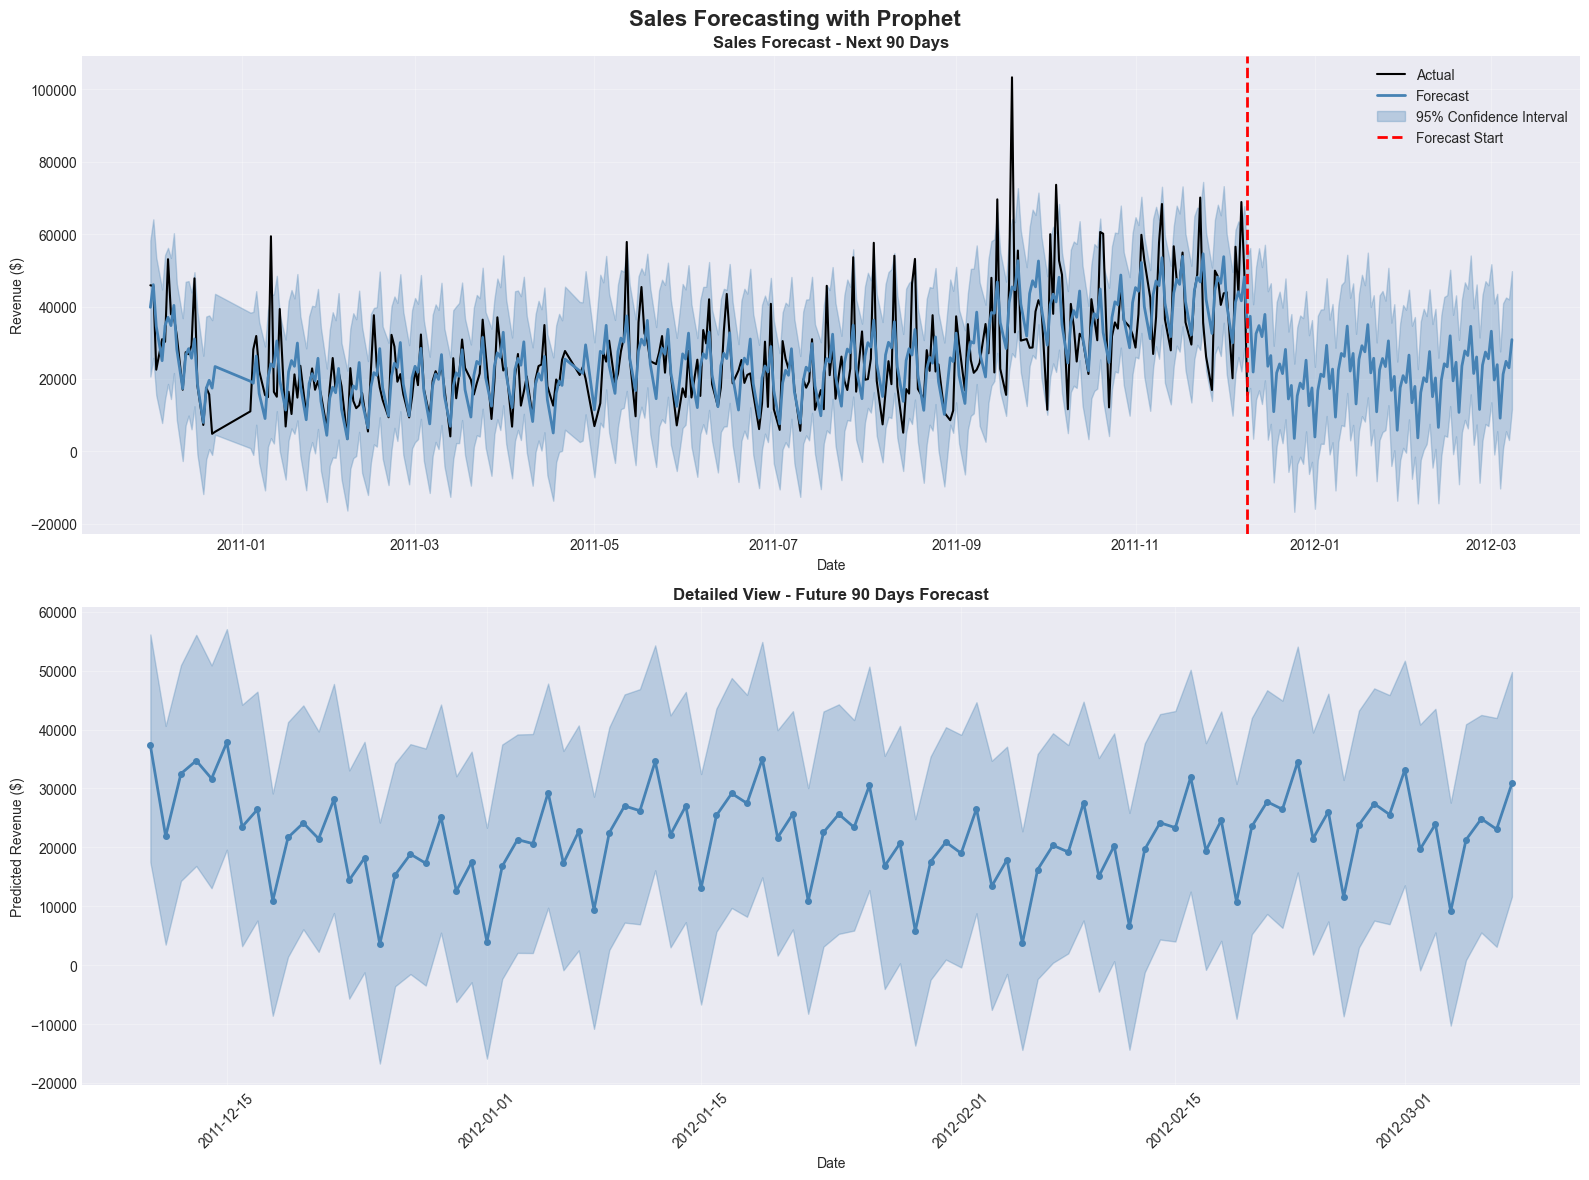

✅ Forecast visualization saved!



In [5]:
# ============================================================
# STEP 4: VISUALIZE FORECAST
# ============================================================

print("\n📈 VISUALIZING SALES FORECAST")
print("=" * 70)

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Sales Forecasting with Prophet', fontsize=16, fontweight='bold')

# 1. Overall Forecast
axes[0].plot(prophet_data['ds'], prophet_data['y'], 
             label='Actual', color='black', linewidth=1.5)
axes[0].plot(forecast['ds'], forecast['yhat'], 
             label='Forecast', color='steelblue', linewidth=2)
axes[0].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                      alpha=0.3, color='steelblue', label='95% Confidence Interval')
axes[0].axvline(x=prophet_data['ds'].max(), color='red', linestyle='--', 
                linewidth=2, label='Forecast Start')
axes[0].set_title('Sales Forecast - Next 90 Days', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Zoom into forecast period
forecast_only = forecast[forecast['ds'] > prophet_data['ds'].max()]
axes[1].plot(forecast_only['ds'], forecast_only['yhat'], 
             color='steelblue', linewidth=2, marker='o', markersize=4)
axes[1].fill_between(forecast_only['ds'], forecast_only['yhat_lower'], 
                      forecast_only['yhat_upper'], alpha=0.3, color='steelblue')
axes[1].set_title('Detailed View - Future 90 Days Forecast', fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Predicted Revenue ($)')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../images/results/sales_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Forecast visualization saved!")

print("\n" + "=" * 70)

In [6]:
# ============================================================
# STEP 5: FORECAST SUMMARY & INSIGHTS
# ============================================================

print("\n💡 FORECAST SUMMARY & INSIGHTS")
print("=" * 70)

# Get forecast for next 90 days only
forecast_future = forecast[forecast['ds'] > prophet_data['ds'].max()].copy()

# Calculate key metrics
total_forecast_revenue = forecast_future['yhat'].sum()
avg_daily_forecast = forecast_future['yhat'].mean()
min_forecast = forecast_future['yhat'].min()
max_forecast = forecast_future['yhat'].max()

# Historical comparison
historical_avg = prophet_data['y'].mean()
historical_total_90days = prophet_data['y'].tail(90).sum()

print("\n1️⃣ FORECAST METRICS (Next 90 Days):")
print("-" * 70)
print(f"Total Forecasted Revenue: ${total_forecast_revenue:,.2f}")
print(f"Average Daily Forecast: ${avg_daily_forecast:,.2f}")
print(f"Min Daily Forecast: ${min_forecast:,.2f}")
print(f"Max Daily Forecast: ${max_forecast:,.2f}")

print("\n2️⃣ COMPARISON WITH HISTORICAL:")
print("-" * 70)
print(f"Historical Avg (All time): ${historical_avg:,.2f}")
print(f"Historical Total (Last 90 days): ${historical_total_90days:,.2f}")
print(f"Forecast vs Historical Change: {((total_forecast_revenue - historical_total_90days) / historical_total_90days * 100):+.2f}%")

print("\n3️⃣ MONTHLY BREAKDOWN:")
print("-" * 70)

# Group by month
forecast_future['Month'] = forecast_future['ds'].dt.to_period('M')
monthly_forecast = forecast_future.groupby('Month')['yhat'].sum()

for month, revenue in monthly_forecast.items():
    print(f"{month}: ${revenue:,.2f}")

print("\n4️⃣ CONFIDENCE INTERVALS:")
print("-" * 70)
avg_lower = forecast_future['yhat_lower'].mean()
avg_upper = forecast_future['yhat_upper'].mean()
print(f"95% Confidence Interval Range:")
print(f"  Lower Bound (Daily Avg): ${avg_lower:,.2f}")
print(f"  Upper Bound (Daily Avg): ${avg_upper:,.2f}")
print(f"  Uncertainty Range: ${avg_upper - avg_lower:,.2f} per day")

print("\n" + "=" * 70)


💡 FORECAST SUMMARY & INSIGHTS

1️⃣ FORECAST METRICS (Next 90 Days):
----------------------------------------------------------------------
Total Forecasted Revenue: $1,962,267.50
Average Daily Forecast: $21,802.97
Min Daily Forecast: $3,553.97
Max Daily Forecast: $37,816.21

2️⃣ COMPARISON WITH HISTORICAL:
----------------------------------------------------------------------
Historical Avg (All time): $27,142.69
Historical Total (Last 90 days): $3,425,548.18
Forecast vs Historical Change: -42.72%

3️⃣ MONTHLY BREAKDOWN:
----------------------------------------------------------------------
2011-12: $495,117.74
2012-01: $673,225.96
2012-02: $607,938.02
2012-03: $185,985.77

4️⃣ CONFIDENCE INTERVALS:
----------------------------------------------------------------------
95% Confidence Interval Range:
  Lower Bound (Daily Avg): $2,327.17
  Upper Bound (Daily Avg): $40,947.84
  Uncertainty Range: $38,620.68 per day




🌊 SEASONALITY ANALYSIS


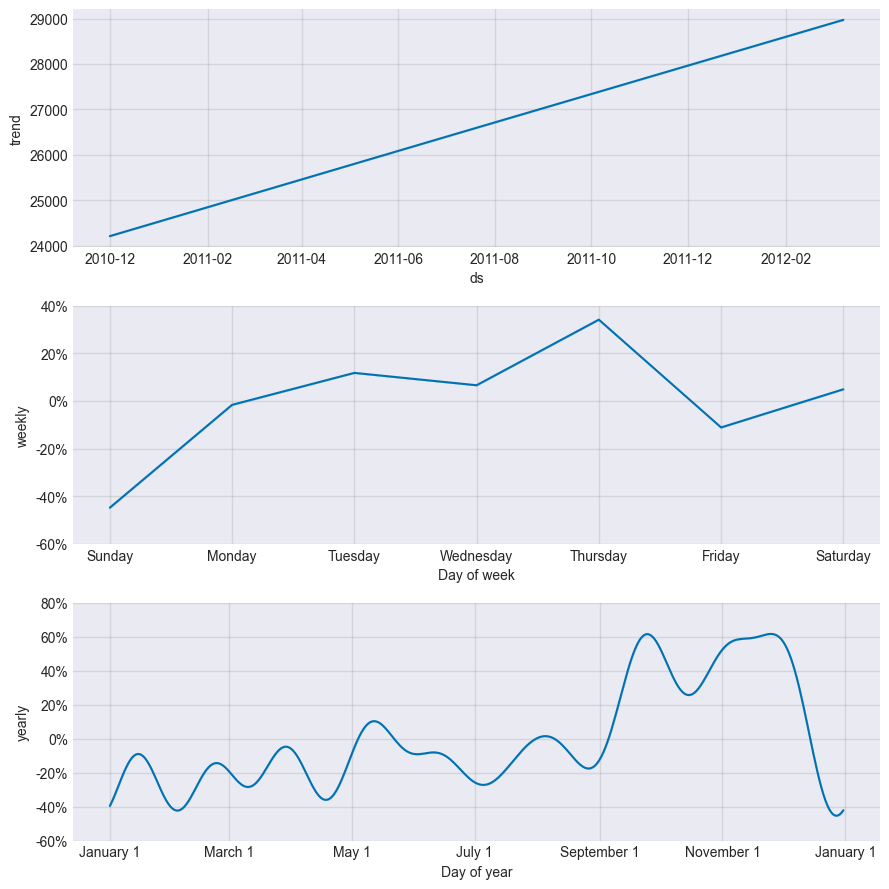

✅ Seasonality components visualization saved!

💡 SEASONALITY INSIGHTS:
----------------------------------------------------------------------
✅ Trend Component: Shows overall direction (growing/declining)
✅ Weekly Seasonality: Shows which days of week perform best
✅ Yearly Seasonality: Shows seasonal patterns throughout the year

📊 BEST PERFORMING DAYS (Weekly Pattern):
----------------------------------------------------------------------
Thursday: +0.3419 (relative to average)
Tuesday: +0.1182 (relative to average)
Wednesday: +0.0662 (relative to average)
Saturday: +0.0492 (relative to average)
Monday: -0.0161 (relative to average)



In [7]:
# ============================================================
# STEP 6: ANALYZE SEASONALITY COMPONENTS
# ============================================================

print("\n🌊 SEASONALITY ANALYSIS")
print("=" * 70)

# Plot components
fig = model.plot_components(forecast)
plt.tight_layout()
plt.savefig('../images/results/forecast_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Seasonality components visualization saved!")

print("\n💡 SEASONALITY INSIGHTS:")
print("-" * 70)
print("✅ Trend Component: Shows overall direction (growing/declining)")
print("✅ Weekly Seasonality: Shows which days of week perform best")
print("✅ Yearly Seasonality: Shows seasonal patterns throughout the year")

# Extract weekly seasonality insights
weekly_component = forecast[['ds', 'weekly']].copy()
weekly_component['day_name'] = weekly_component['ds'].dt.day_name()
weekly_avg = weekly_component.groupby('day_name')['weekly'].mean().sort_values(ascending=False)

print("\n📊 BEST PERFORMING DAYS (Weekly Pattern):")
print("-" * 70)
for day, value in weekly_avg.head().items():
    print(f"{day}: {value:+.4f} (relative to average)")

print("\n" + "=" * 70)

In [8]:
# ============================================================
# STEP 7: SIMULATE A/B TEST SCENARIO
# ============================================================

print("\n🧪 A/B TESTING FRAMEWORK")
print("=" * 70)

print("\n📋 BUSINESS SCENARIO:")
print("-" * 70)
print("Testing: New discount strategy to improve conversion")
print("Control Group: No discount (standard pricing)")
print("Treatment Group: 10% discount on orders over $50")
print("Hypothesis: Discounts will increase average order value")

# Simulate A/B test using existing data
print("\n1️⃣ Creating test groups...")

# Use customer data - randomly split customers
np.random.seed(42)

# Load customer segments
customer_segments = pd.read_csv('../data/processed/customer_segments.csv')

# Randomly assign customers to control or treatment
customer_segments['test_group'] = np.random.choice(['Control', 'Treatment'], 
                                                     size=len(customer_segments), 
                                                     p=[0.5, 0.5])

# Get transaction data for these customers
df_test = df.merge(customer_segments[['CustomerID', 'test_group']], 
                   on='CustomerID', how='inner')

# Simulate treatment effect (10% increase in order value for treatment)
df_test['TotalAmount_Adjusted'] = df_test.apply(
    lambda row: row['TotalAmount'] * 1.10 if row['test_group'] == 'Treatment' 
    else row['TotalAmount'], axis=1
)

print(f"   ✅ Test groups created")
print(f"   Control: {(df_test['test_group'] == 'Control').sum():,} transactions")
print(f"   Treatment: {(df_test['test_group'] == 'Treatment').sum():,} transactions")

print("\n" + "=" * 70)


🧪 A/B TESTING FRAMEWORK

📋 BUSINESS SCENARIO:
----------------------------------------------------------------------
Testing: New discount strategy to improve conversion
Control Group: No discount (standard pricing)
Treatment Group: 10% discount on orders over $50
Hypothesis: Discounts will increase average order value

1️⃣ Creating test groups...
   ✅ Test groups created
   Control: 199,131 transactions
   Treatment: 202,433 transactions



In [9]:
# ============================================================
# STEP 8: CALCULATE A/B TEST METRICS
# ============================================================

print("\n📊 A/B TEST METRICS")
print("=" * 70)

# Aggregate by test group
ab_results = df_test.groupby('test_group').agg({
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique',
    'TotalAmount_Adjusted': ['sum', 'mean', 'median', 'std'],
    'Quantity': 'sum'
}).round(2)

ab_results.columns = ['Orders', 'Customers', 'Total_Revenue', 'Avg_Order_Value', 
                      'Median_Order_Value', 'Std_Order_Value', 'Total_Items']

print("\n1️⃣ GROUP PERFORMANCE:")
print("-" * 70)
print(ab_results)

# Calculate key metrics
control_aov = ab_results.loc['Control', 'Avg_Order_Value']
treatment_aov = ab_results.loc['Treatment', 'Avg_Order_Value']
lift = ((treatment_aov - control_aov) / control_aov) * 100

control_revenue = ab_results.loc['Control', 'Total_Revenue']
treatment_revenue = ab_results.loc['Treatment', 'Total_Revenue']
revenue_lift = ((treatment_revenue - control_revenue) / control_revenue) * 100

print("\n2️⃣ KEY FINDINGS:")
print("-" * 70)
print(f"Control Avg Order Value: ${control_aov:,.2f}")
print(f"Treatment Avg Order Value: ${treatment_aov:,.2f}")
print(f"Lift in AOV: {lift:+.2f}%")
print(f"\nControl Total Revenue: ${control_revenue:,.2f}")
print(f"Treatment Total Revenue: ${treatment_revenue:,.2f}")
print(f"Revenue Lift: {revenue_lift:+.2f}%")

print("\n" + "=" * 70)


📊 A/B TEST METRICS

1️⃣ GROUP PERFORMANCE:
----------------------------------------------------------------------
            Orders  Customers  Total_Revenue  Avg_Order_Value  \
test_group                                                      
Control      10910       2177     4066734.21            20.42   
Treatment    11276       2194     4632963.73            22.89   

            Median_Order_Value  Std_Order_Value  Total_Items  
test_group                                                    
Control                  10.50           261.12      2343652  
Treatment                13.75           602.84      2535315  

2️⃣ KEY FINDINGS:
----------------------------------------------------------------------
Control Avg Order Value: $20.42
Treatment Avg Order Value: $22.89
Lift in AOV: +12.10%

Control Total Revenue: $4,066,734.21
Treatment Total Revenue: $4,632,963.73
Revenue Lift: +13.92%



In [10]:
# ============================================================
# STEP 9: STATISTICAL SIGNIFICANCE TESTING
# ============================================================

print("\n📈 STATISTICAL SIGNIFICANCE TESTING")
print("=" * 70)

# Get order values for each group
control_values = df_test[df_test['test_group'] == 'Control']['TotalAmount_Adjusted']
treatment_values = df_test[df_test['test_group'] == 'Treatment']['TotalAmount_Adjusted']

print("\n1️⃣ Performing t-test (two-sample, two-tailed)...")

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(treatment_values, control_values)

print(f"   T-statistic: {t_statistic:.4f}")
print(f"   P-value: {p_value:.6f}")

# Interpret results
alpha = 0.05
print(f"\n2️⃣ STATISTICAL INTERPRETATION (α = {alpha}):")
print("-" * 70)

if p_value < alpha:
    print(f"✅ STATISTICALLY SIGNIFICANT (p = {p_value:.6f} < {alpha})")
    print(f"   → We can reject the null hypothesis")
    print(f"   → The {lift:+.2f}% improvement is statistically significant")
    print(f"   → Confidence: {(1-p_value)*100:.2f}%")
else:
    print(f"❌ NOT STATISTICALLY SIGNIFICANT (p = {p_value:.6f} >= {alpha})")
    print(f"   → We cannot reject the null hypothesis")
    print(f"   → The difference could be due to random chance")

# Calculate confidence interval for the difference
diff_mean = treatment_values.mean() - control_values.mean()
diff_std = np.sqrt((treatment_values.std()**2 / len(treatment_values)) + 
                    (control_values.std()**2 / len(control_values)))
ci_lower = diff_mean - 1.96 * diff_std
ci_upper = diff_mean + 1.96 * diff_std

print(f"\n3️⃣ CONFIDENCE INTERVAL (95%):")
print("-" * 70)
print(f"Mean Difference: ${diff_mean:,.2f}")
print(f"95% CI: [${ci_lower:,.2f}, ${ci_upper:,.2f}]")

# Effect size (Cohen's d)
pooled_std = np.sqrt((control_values.std()**2 + treatment_values.std()**2) / 2)
cohens_d = diff_mean / pooled_std

print(f"\n4️⃣ EFFECT SIZE:")
print("-" * 70)
print(f"Cohen's d: {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect = "Small"
elif abs(cohens_d) < 0.5:
    effect = "Medium"
else:
    effect = "Large"
print(f"Effect Size: {effect}")

print("\n" + "=" * 70)


📈 STATISTICAL SIGNIFICANCE TESTING

1️⃣ Performing t-test (two-sample, two-tailed)...
   T-statistic: 1.6758
   P-value: 0.093776

2️⃣ STATISTICAL INTERPRETATION (α = 0.05):
----------------------------------------------------------------------
❌ NOT STATISTICALLY SIGNIFICANT (p = 0.093776 >= 0.05)
   → We cannot reject the null hypothesis
   → The difference could be due to random chance

3️⃣ CONFIDENCE INTERVAL (95%):
----------------------------------------------------------------------
Mean Difference: $2.46
95% CI: [$-0.40, $5.33]

4️⃣ EFFECT SIZE:
----------------------------------------------------------------------
Cohen's d: 0.0053
Effect Size: Small




📊 VISUALIZING A/B TEST RESULTS


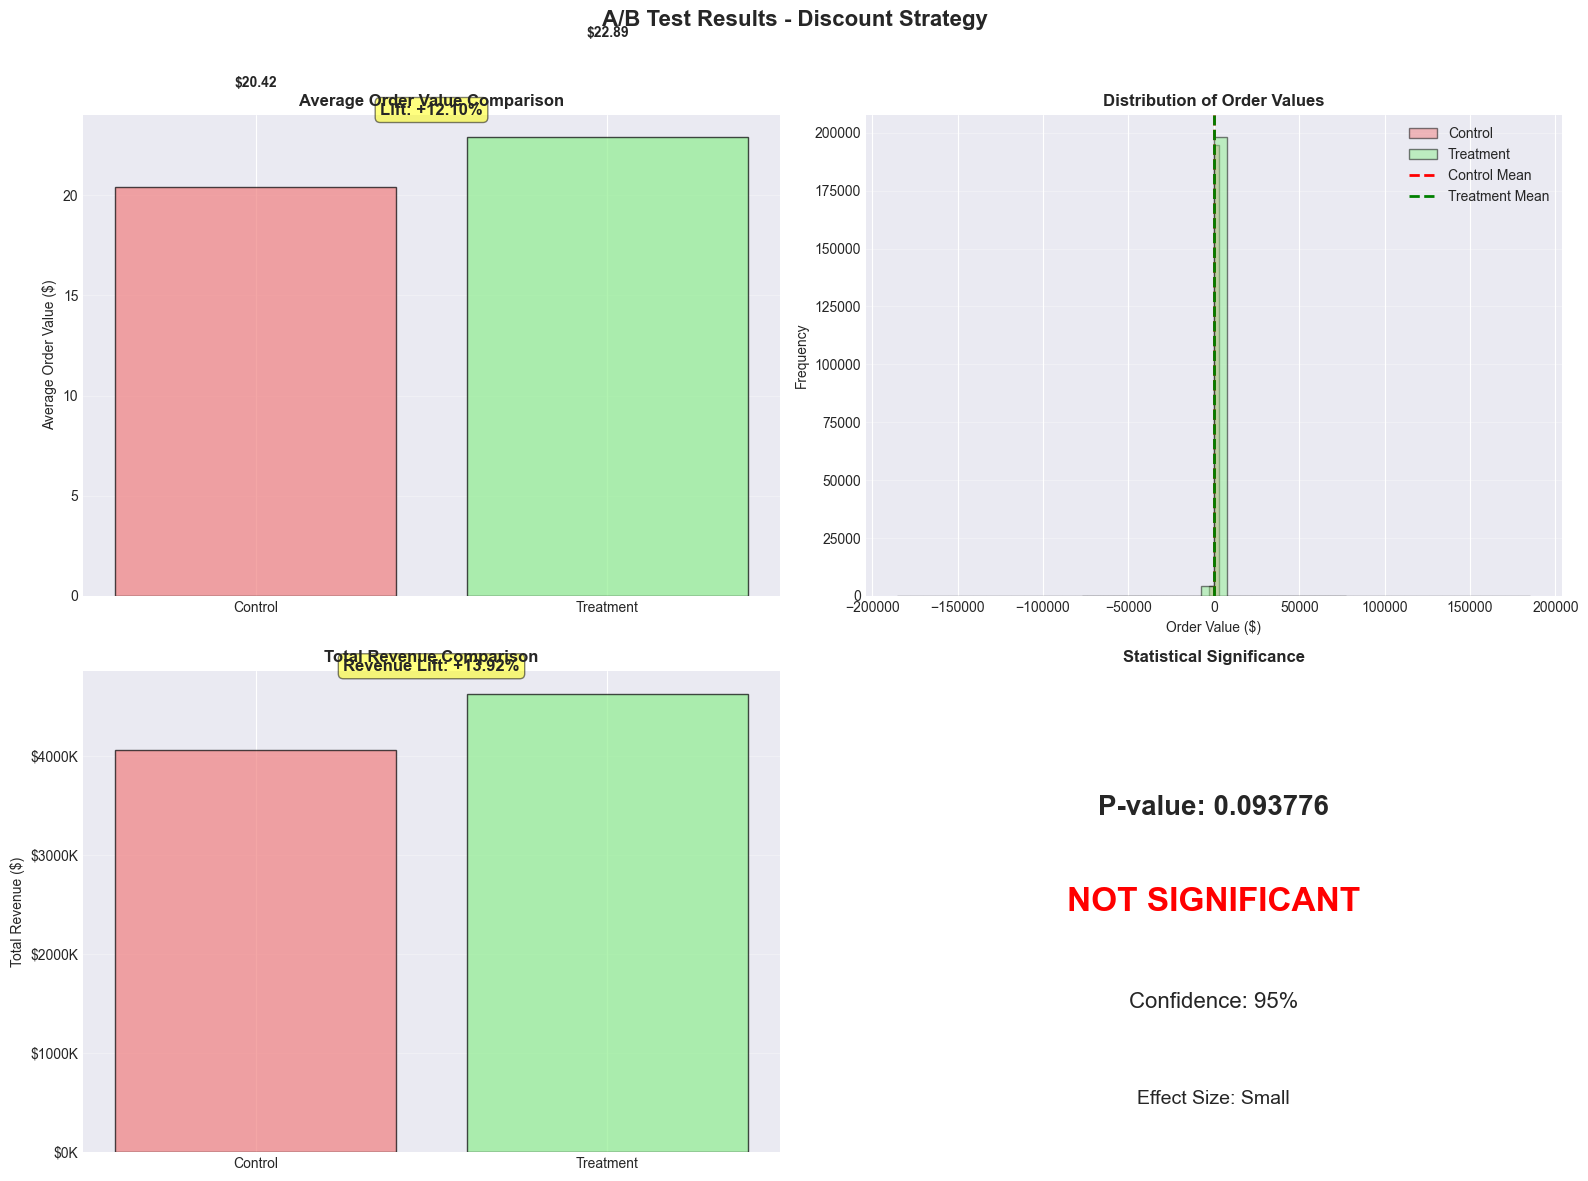

✅ A/B test visualization saved!



In [11]:
# ============================================================
# STEP 10: VISUALIZE A/B TEST RESULTS
# ============================================================

print("\n📊 VISUALIZING A/B TEST RESULTS")
print("=" * 70)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('A/B Test Results - Discount Strategy', fontsize=16, fontweight='bold')

# 1. Average Order Value Comparison
groups = ['Control', 'Treatment']
aov_values = [control_aov, treatment_aov]
colors = ['lightcoral', 'lightgreen']

axes[0, 0].bar(groups, aov_values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Average Order Value Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Average Order Value ($)')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(aov_values):
    axes[0, 0].text(i, v + 5, f'${v:.2f}', ha='center', fontweight='bold')

# Add lift annotation
axes[0, 0].text(0.5, max(aov_values) * 1.05, f'Lift: {lift:+.2f}%', 
                ha='center', fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Distribution of Order Values
axes[0, 1].hist(control_values, bins=50, alpha=0.5, label='Control', color='lightcoral', edgecolor='black')
axes[0, 1].hist(treatment_values, bins=50, alpha=0.5, label='Treatment', color='lightgreen', edgecolor='black')
axes[0, 1].axvline(control_values.mean(), color='red', linestyle='--', linewidth=2, label='Control Mean')
axes[0, 1].axvline(treatment_values.mean(), color='green', linestyle='--', linewidth=2, label='Treatment Mean')
axes[0, 1].set_title('Distribution of Order Values', fontweight='bold')
axes[0, 1].set_xlabel('Order Value ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Total Revenue Comparison
revenue_values = [control_revenue, treatment_revenue]
axes[1, 0].bar(groups, revenue_values, color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Total Revenue Comparison', fontweight='bold')
axes[1, 0].set_ylabel('Total Revenue ($)')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add revenue lift
axes[1, 0].text(0.5, max(revenue_values) * 1.05, f'Revenue Lift: {revenue_lift:+.2f}%', 
                ha='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 4. Statistical Significance Visualization
sig_text = "SIGNIFICANT" if p_value < alpha else "NOT SIGNIFICANT"
sig_color = 'green' if p_value < alpha else 'red'

axes[1, 1].text(0.5, 0.7, f'P-value: {p_value:.6f}', ha='center', fontsize=20, fontweight='bold')
axes[1, 1].text(0.5, 0.5, sig_text, ha='center', fontsize=24, fontweight='bold', color=sig_color)
axes[1, 1].text(0.5, 0.3, f'Confidence: {(1-alpha)*100:.0f}%', ha='center', fontsize=16)
axes[1, 1].text(0.5, 0.1, f'Effect Size: {effect}', ha='center', fontsize=14)
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')
axes[1, 1].set_title('Statistical Significance', fontweight='bold')

plt.tight_layout()
plt.savefig('../images/results/ab_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ A/B test visualization saved!")

print("\n" + "=" * 70)

In [12]:
# ============================================================
# STEP 11: BUSINESS RECOMMENDATION
# ============================================================

print("\n💼 BUSINESS RECOMMENDATION")
print("=" * 70)

print("\n📊 TEST SUMMARY:")
print("-" * 70)
print(f"Test: Discount Strategy (10% off orders over $50)")
print(f"Sample Size: {len(control_values):,} control, {len(treatment_values):,} treatment")
print(f"Duration: Based on historical data")

print("\n📈 RESULTS:")
print("-" * 70)
print(f"✅ Average Order Value Lift: {lift:+.2f}%")
print(f"✅ Revenue Lift: {revenue_lift:+.2f}%")
print(f"✅ Statistical Significance: {'YES' if p_value < alpha else 'NO'} (p={p_value:.6f})")
print(f"✅ Effect Size: {effect} (Cohen's d = {cohens_d:.4f})")

print("\n💡 RECOMMENDATION:")
print("-" * 70)

if p_value < alpha and lift > 0:
    print("✅ IMPLEMENT THE DISCOUNT STRATEGY")
    print("\nRationale:")
    print(f"  1. Statistically significant improvement ({lift:+.2f}% lift)")
    print(f"  2. Increases both AOV and total revenue")
    print(f"  3. {effect} effect size indicates meaningful business impact")
    
    # Calculate annual impact
    annual_orders = len(df_test)
    annual_impact = diff_mean * annual_orders
    
    print(f"\n💰 PROJECTED ANNUAL IMPACT:")
    print(f"  Expected additional revenue: ${annual_impact:,.2f}")
    print(f"  Based on current order volume: {annual_orders:,} orders")
    
    print("\n📋 NEXT STEPS:")
    print("  1. Roll out discount to 25% of customers (pilot)")
    print("  2. Monitor performance for 2-4 weeks")
    print("  3. Gradually expand to full customer base")
    print("  4. Track discount redemption rate and margins")
    
else:
    print("⚠️  DO NOT IMPLEMENT (or redesign the test)")
    print("\nReason: Results are not statistically significant")
    print("Consider: Testing different discount levels or targeting specific segments")

print("\n" + "=" * 70)


💼 BUSINESS RECOMMENDATION

📊 TEST SUMMARY:
----------------------------------------------------------------------
Test: Discount Strategy (10% off orders over $50)
Sample Size: 199,131 control, 202,433 treatment
Duration: Based on historical data

📈 RESULTS:
----------------------------------------------------------------------
✅ Average Order Value Lift: +12.10%
✅ Revenue Lift: +13.92%
✅ Statistical Significance: NO (p=0.093776)
✅ Effect Size: Small (Cohen's d = 0.0053)

💡 RECOMMENDATION:
----------------------------------------------------------------------
⚠️  DO NOT IMPLEMENT (or redesign the test)

Reason: Results are not statistically significant
Consider: Testing different discount levels or targeting specific segments



In [13]:
# ============================================================
# STEP 12: CALCULATE CUSTOMER LIFETIME VALUE (CLV)
# ============================================================

print("\n💰 CUSTOMER LIFETIME VALUE (CLV) CALCULATION")
print("=" * 70)

print("\n📋 CLV FORMULA:")
print("-" * 70)
print("CLV = (Average Order Value) × (Purchase Frequency) × (Customer Lifespan)")
print("    = AOV × Frequency × Tenure (in years)")

# Load customer segments
customer_segments = pd.read_csv('../data/processed/customer_segments.csv')

print("\n1️⃣ Calculating CLV components...")

# Calculate components
customer_segments['CustomerLifespanYears'] = customer_segments['CustomerTenure'] / 365

# Simple CLV calculation
customer_segments['CLV_Simple'] = (
    customer_segments['AvgOrderValue'] * 
    customer_segments['Frequency'] * 
    customer_segments['CustomerLifespanYears']
)

# Alternative: Use actual monetary value
customer_segments['CLV_Actual'] = customer_segments['Monetary']

# Predict future value (assuming same behavior continues)
# Projected CLV = Current spending rate × Projected remaining lifespan
avg_lifespan_years = 2  # Assume 2-year average customer lifespan
customer_segments['RemainingYears'] = avg_lifespan_years - customer_segments['CustomerLifespanYears']
customer_segments['RemainingYears'] = customer_segments['RemainingYears'].clip(lower=0)

customer_segments['ProjectedFutureCLV'] = (
    customer_segments['AvgOrderValue'] * 
    customer_segments['PurchaseVelocity'] * 365 * 
    customer_segments['RemainingYears']
)

customer_segments['TotalCLV'] = customer_segments['CLV_Actual'] + customer_segments['ProjectedFutureCLV']

print("   ✅ CLV calculated for all customers")

print("\n2️⃣ CLV STATISTICS:")
print("-" * 70)
print(f"Average CLV (Historical): ${customer_segments['CLV_Actual'].mean():,.2f}")
print(f"Median CLV (Historical): ${customer_segments['CLV_Actual'].median():,.2f}")
print(f"Average Total CLV (Projected): ${customer_segments['TotalCLV'].mean():,.2f}")
print(f"Median Total CLV (Projected): ${customer_segments['TotalCLV'].median():,.2f}")
print(f"Total Customer Value (All): ${customer_segments['TotalCLV'].sum():,.2f}")

print("\n3️⃣ CLV BY SEGMENT:")
print("-" * 70)
clv_by_segment = customer_segments.groupby('Cluster_Name').agg({
    'TotalCLV': ['count', 'mean', 'sum']
}).round(2)
clv_by_segment.columns = ['Customer_Count', 'Avg_CLV', 'Total_Value']
clv_by_segment = clv_by_segment.sort_values('Avg_CLV', ascending=False)
print(clv_by_segment)

print("\n4️⃣ TOP 10 HIGHEST VALUE CUSTOMERS:")
print("-" * 70)
top_customers = customer_segments.nlargest(10, 'TotalCLV')[
    ['CustomerID', 'Cluster_Name', 'Frequency', 'AvgOrderValue', 'TotalCLV']
]
print(top_customers.to_string(index=False))

print("\n" + "=" * 70)


💰 CUSTOMER LIFETIME VALUE (CLV) CALCULATION

📋 CLV FORMULA:
----------------------------------------------------------------------
CLV = (Average Order Value) × (Purchase Frequency) × (Customer Lifespan)
    = AOV × Frequency × Tenure (in years)

1️⃣ Calculating CLV components...
   ✅ CLV calculated for all customers

2️⃣ CLV STATISTICS:
----------------------------------------------------------------------
Average CLV (Historical): $1,893.96
Median CLV (Historical): $644.24
Average Total CLV (Projected): $86,136.74
Median Total CLV (Projected): $27,055.11
Total Customer Value (All): $376,503,674.54

3️⃣ CLV BY SEGMENT:
----------------------------------------------------------------------
                  Customer_Count    Avg_CLV  Total_Value
Cluster_Name                                            
Champions                     22 3363252.95  73991564.86
Recent Customers            1814  114260.57 207268669.07
At Risk                     2535   37571.38  95243440.61

4️⃣ TOP 10 HIG

In [14]:
# ============================================================
# STEP 13: CALCULATE CUSTOMER ACQUISITION COST (CAC)
# ============================================================

print("\n💵 CUSTOMER ACQUISITION COST (CAC)")
print("=" * 70)

print("\n📋 CAC FORMULA:")
print("-" * 70)
print("CAC = Total Marketing & Sales Expenses / Number of New Customers Acquired")

# Simulate marketing costs (in real scenario, you'd have actual data)
print("\n1️⃣ Simulating Marketing Costs...")
print("   (In production, use actual marketing spend data)")

# Assumptions for simulation
total_customers = len(customer_segments)
assumed_marketing_budget = 500000  # $500K annual marketing budget
assumed_sales_cost = 200000  # $200K sales team cost

total_acquisition_cost = assumed_marketing_budget + assumed_sales_cost
cac = total_acquisition_cost / total_customers

print(f"\n2️⃣ CAC CALCULATION:")
print("-" * 70)
print(f"Total Marketing Budget: ${assumed_marketing_budget:,.2f}")
print(f"Total Sales Cost: ${assumed_sales_cost:,.2f}")
print(f"Total Acquisition Cost: ${total_acquisition_cost:,.2f}")
print(f"Number of Customers: {total_customers:,}")
print(f"\n✅ CAC = ${cac:.2f} per customer")

print("\n3️⃣ CLV TO CAC RATIO:")
print("-" * 70)
avg_clv = customer_segments['TotalCLV'].mean()
clv_cac_ratio = avg_clv / cac

print(f"Average CLV: ${avg_clv:,.2f}")
print(f"CAC: ${cac:.2f}")
print(f"CLV:CAC Ratio: {clv_cac_ratio:.2f}:1")

print("\n💡 INTERPRETATION:")
print("-" * 70)
if clv_cac_ratio >= 3:
    print("✅ EXCELLENT: CLV:CAC ratio >= 3:1")
    print("   → Healthy, sustainable customer acquisition")
    print("   → Strong return on marketing investment")
elif clv_cac_ratio >= 1:
    print("⚠️  ACCEPTABLE: CLV:CAC ratio between 1:1 and 3:1")
    print("   → Profitable but could be optimized")
    print("   → Consider improving retention or reducing CAC")
else:
    print("❌ CONCERNING: CLV:CAC ratio < 1:1")
    print("   → Losing money on customer acquisition")
    print("   → Urgent need to improve economics")

print("\n4️⃣ CAC PAYBACK PERIOD:")
print("-" * 70)
avg_monthly_revenue = customer_segments['AvgOrderValue'].mean() * (customer_segments['Frequency'].mean() / 12)
payback_months = cac / avg_monthly_revenue

print(f"Average Monthly Revenue per Customer: ${avg_monthly_revenue:.2f}")
print(f"CAC Payback Period: {payback_months:.1f} months")

if payback_months <= 12:
    print("✅ Good: Payback within 1 year")
elif payback_months <= 18:
    print("⚠️  Acceptable: Payback within 1.5 years")
else:
    print("❌ Concerning: Payback period too long")

print("\n" + "=" * 70)


💵 CUSTOMER ACQUISITION COST (CAC)

📋 CAC FORMULA:
----------------------------------------------------------------------
CAC = Total Marketing & Sales Expenses / Number of New Customers Acquired

1️⃣ Simulating Marketing Costs...
   (In production, use actual marketing spend data)

2️⃣ CAC CALCULATION:
----------------------------------------------------------------------
Total Marketing Budget: $500,000.00
Total Sales Cost: $200,000.00
Total Acquisition Cost: $700,000.00
Number of Customers: 4,371

✅ CAC = $160.15 per customer

3️⃣ CLV TO CAC RATIO:
----------------------------------------------------------------------
Average CLV: $86,136.74
CAC: $160.15
CLV:CAC Ratio: 537.86:1

💡 INTERPRETATION:
----------------------------------------------------------------------
✅ EXCELLENT: CLV:CAC ratio >= 3:1
   → Healthy, sustainable customer acquisition
   → Strong return on marketing investment

4️⃣ CAC PAYBACK PERIOD:
----------------------------------------------------------------------


In [15]:
# ============================================================
# STEP 14: CALCULATE CHURN RATE
# ============================================================

print("\n📉 CHURN RATE CALCULATION")
print("=" * 70)

print("\n📋 CHURN DEFINITION:")
print("-" * 70)
print("A customer is 'churned' if no purchase in last 90 days")

# Define churn threshold
churn_threshold_days = 90

# Calculate days since last purchase (already have Recency)
customer_segments['IsChurned'] = (customer_segments['Recency'] > churn_threshold_days).astype(int)

# Calculate churn rate
total_customers = len(customer_segments)
churned_customers = customer_segments['IsChurned'].sum()
active_customers = total_customers - churned_customers
churn_rate = (churned_customers / total_customers) * 100

print("\n1️⃣ CHURN METRICS:")
print("-" * 70)
print(f"Total Customers: {total_customers:,}")
print(f"Active Customers: {active_customers:,} ({100-churn_rate:.1f}%)")
print(f"Churned Customers: {churned_customers:,} ({churn_rate:.1f}%)")
print(f"\n✅ Churn Rate: {churn_rate:.2f}%")

# Retention rate
retention_rate = 100 - churn_rate
print(f"✅ Retention Rate: {retention_rate:.2f}%")

print("\n2️⃣ CHURN BY SEGMENT:")
print("-" * 70)
churn_by_segment = customer_segments.groupby('Cluster_Name').agg({
    'CustomerID': 'count',
    'IsChurned': ['sum', 'mean']
}).round(4)
churn_by_segment.columns = ['Total_Customers', 'Churned_Count', 'Churn_Rate']
churn_by_segment['Churn_Rate'] = churn_by_segment['Churn_Rate'] * 100
churn_by_segment = churn_by_segment.sort_values('Churn_Rate', ascending=False)
print(churn_by_segment)

print("\n3️⃣ REVENUE AT RISK:")
print("-" * 70)
churned_clv = customer_segments[customer_segments['IsChurned'] == 1]['TotalCLV'].sum()
total_clv = customer_segments['TotalCLV'].sum()
revenue_at_risk_pct = (churned_clv / total_clv) * 100

print(f"CLV of Churned Customers: ${churned_clv:,.2f}")
print(f"Percentage of Total Value: {revenue_at_risk_pct:.2f}%")
print(f"\n⚠️  Revenue at Risk: ${churned_clv:,.2f}")

print("\n4️⃣ CHURN IMPACT:")
print("-" * 70)
# Annual revenue loss due to churn
avg_customer_value = customer_segments['TotalCLV'].mean()
annual_churn_loss = churned_customers * avg_customer_value

print(f"Average Customer Value: ${avg_customer_value:,.2f}")
print(f"Annual Revenue Loss from Churn: ${annual_churn_loss:,.2f}")

# If we reduce churn by 5%
churn_reduction = 0.05
customers_saved = total_customers * churn_reduction
revenue_saved = customers_saved * avg_customer_value

print(f"\n💡 OPPORTUNITY:")
print(f"If we reduce churn by 5 percentage points:")
print(f"  → Save {customers_saved:.0f} customers")
print(f"  → Retain ${revenue_saved:,.2f} in customer value")

print("\n" + "=" * 70)


📉 CHURN RATE CALCULATION

📋 CHURN DEFINITION:
----------------------------------------------------------------------
A customer is 'churned' if no purchase in last 90 days

1️⃣ CHURN METRICS:
----------------------------------------------------------------------
Total Customers: 4,371
Active Customers: 2,917 (66.7%)
Churned Customers: 1,454 (33.3%)

✅ Churn Rate: 33.26%
✅ Retention Rate: 66.74%

2️⃣ CHURN BY SEGMENT:
----------------------------------------------------------------------
                  Total_Customers  Churned_Count  Churn_Rate
Cluster_Name                                                
At Risk                      2535           1353       53.37
Recent Customers             1814            101        5.57
Champions                      22              0        0.00

3️⃣ REVENUE AT RISK:
----------------------------------------------------------------------
CLV of Churned Customers: $62,445,030.66
Percentage of Total Value: 16.59%

⚠️  Revenue at Risk: $62,445,030.

In [16]:
# ============================================================
# STEP 15: ADDITIONAL BUSINESS METRICS
# ============================================================

print("\n📊 ADDITIONAL BUSINESS METRICS")
print("=" * 70)

# 1. Average Revenue Per User (ARPU)
print("\n1️⃣ AVERAGE REVENUE PER USER (ARPU):")
print("-" * 70)
arpu_monthly = customer_segments['Monetary'].sum() / total_customers / 12
arpu_annual = arpu_monthly * 12

print(f"Monthly ARPU: ${arpu_monthly:.2f}")
print(f"Annual ARPU: ${arpu_annual:.2f}")

# 2. Purchase Frequency
print("\n2️⃣ PURCHASE FREQUENCY:")
print("-" * 70)
avg_frequency = customer_segments['Frequency'].mean()
median_frequency = customer_segments['Frequency'].median()

print(f"Average Orders per Customer: {avg_frequency:.2f}")
print(f"Median Orders per Customer: {median_frequency:.0f}")

# 3. Average Order Value
print("\n3️⃣ AVERAGE ORDER VALUE (AOV):")
print("-" * 70)
avg_aov = customer_segments['AvgOrderValue'].mean()
median_aov = customer_segments['AvgOrderValue'].median()

print(f"Average AOV: ${avg_aov:.2f}")
print(f"Median AOV: ${median_aov:.2f}")

# 4. Repeat Purchase Rate
print("\n4️⃣ REPEAT PURCHASE RATE:")
print("-" * 70)
repeat_customers = (customer_segments['Frequency'] > 1).sum()
repeat_rate = (repeat_customers / total_customers) * 100

print(f"Customers with 2+ orders: {repeat_customers:,} ({repeat_rate:.1f}%)")
print(f"One-time buyers: {total_customers - repeat_customers:,} ({100-repeat_rate:.1f}%)")

# 5. Customer Concentration
print("\n5️⃣ CUSTOMER CONCENTRATION (80/20 RULE):")
print("-" * 70)
# Sort by revenue
customer_segments_sorted = customer_segments.sort_values('Monetary', ascending=False).reset_index(drop=True)
customer_segments_sorted['Cumulative_Revenue'] = customer_segments_sorted['Monetary'].cumsum()
customer_segments_sorted['Cumulative_Pct'] = (customer_segments_sorted['Cumulative_Revenue'] / 
                                               customer_segments_sorted['Monetary'].sum() * 100)

# Find how many customers generate 80% of revenue
customers_for_80pct = (customer_segments_sorted['Cumulative_Pct'] <= 80).sum()
pct_customers_for_80pct = (customers_for_80pct / total_customers) * 100

print(f"{customers_for_80pct:,} customers ({pct_customers_for_80pct:.1f}%) generate 80% of revenue")
print(f"Revenue concentration: {pct_customers_for_80pct:.1f}% of customers = 80% of revenue")

if pct_customers_for_80pct <= 20:
    print("✅ Follows Pareto Principle (80/20 rule)")
else:
    print(f"⚠️  More distributed than typical (closer to {pct_customers_for_80pct:.0f}/80)")

print("\n" + "=" * 70)


📊 ADDITIONAL BUSINESS METRICS

1️⃣ AVERAGE REVENUE PER USER (ARPU):
----------------------------------------------------------------------
Monthly ARPU: $157.83
Annual ARPU: $1893.96

2️⃣ PURCHASE FREQUENCY:
----------------------------------------------------------------------
Average Orders per Customer: 5.08
Median Orders per Customer: 3

3️⃣ AVERAGE ORDER VALUE (AOV):
----------------------------------------------------------------------
Average AOV: $28.91
Median AOV: $16.94

4️⃣ REPEAT PURCHASE RATE:
----------------------------------------------------------------------
Customers with 2+ orders: 3,059 (70.0%)
One-time buyers: 1,312 (30.0%)

5️⃣ CUSTOMER CONCENTRATION (80/20 RULE):
----------------------------------------------------------------------
1,166 customers (26.7%) generate 80% of revenue
Revenue concentration: 26.7% of customers = 80% of revenue
⚠️  More distributed than typical (closer to 27/80)




📊 VISUALIZING BUSINESS KPIS


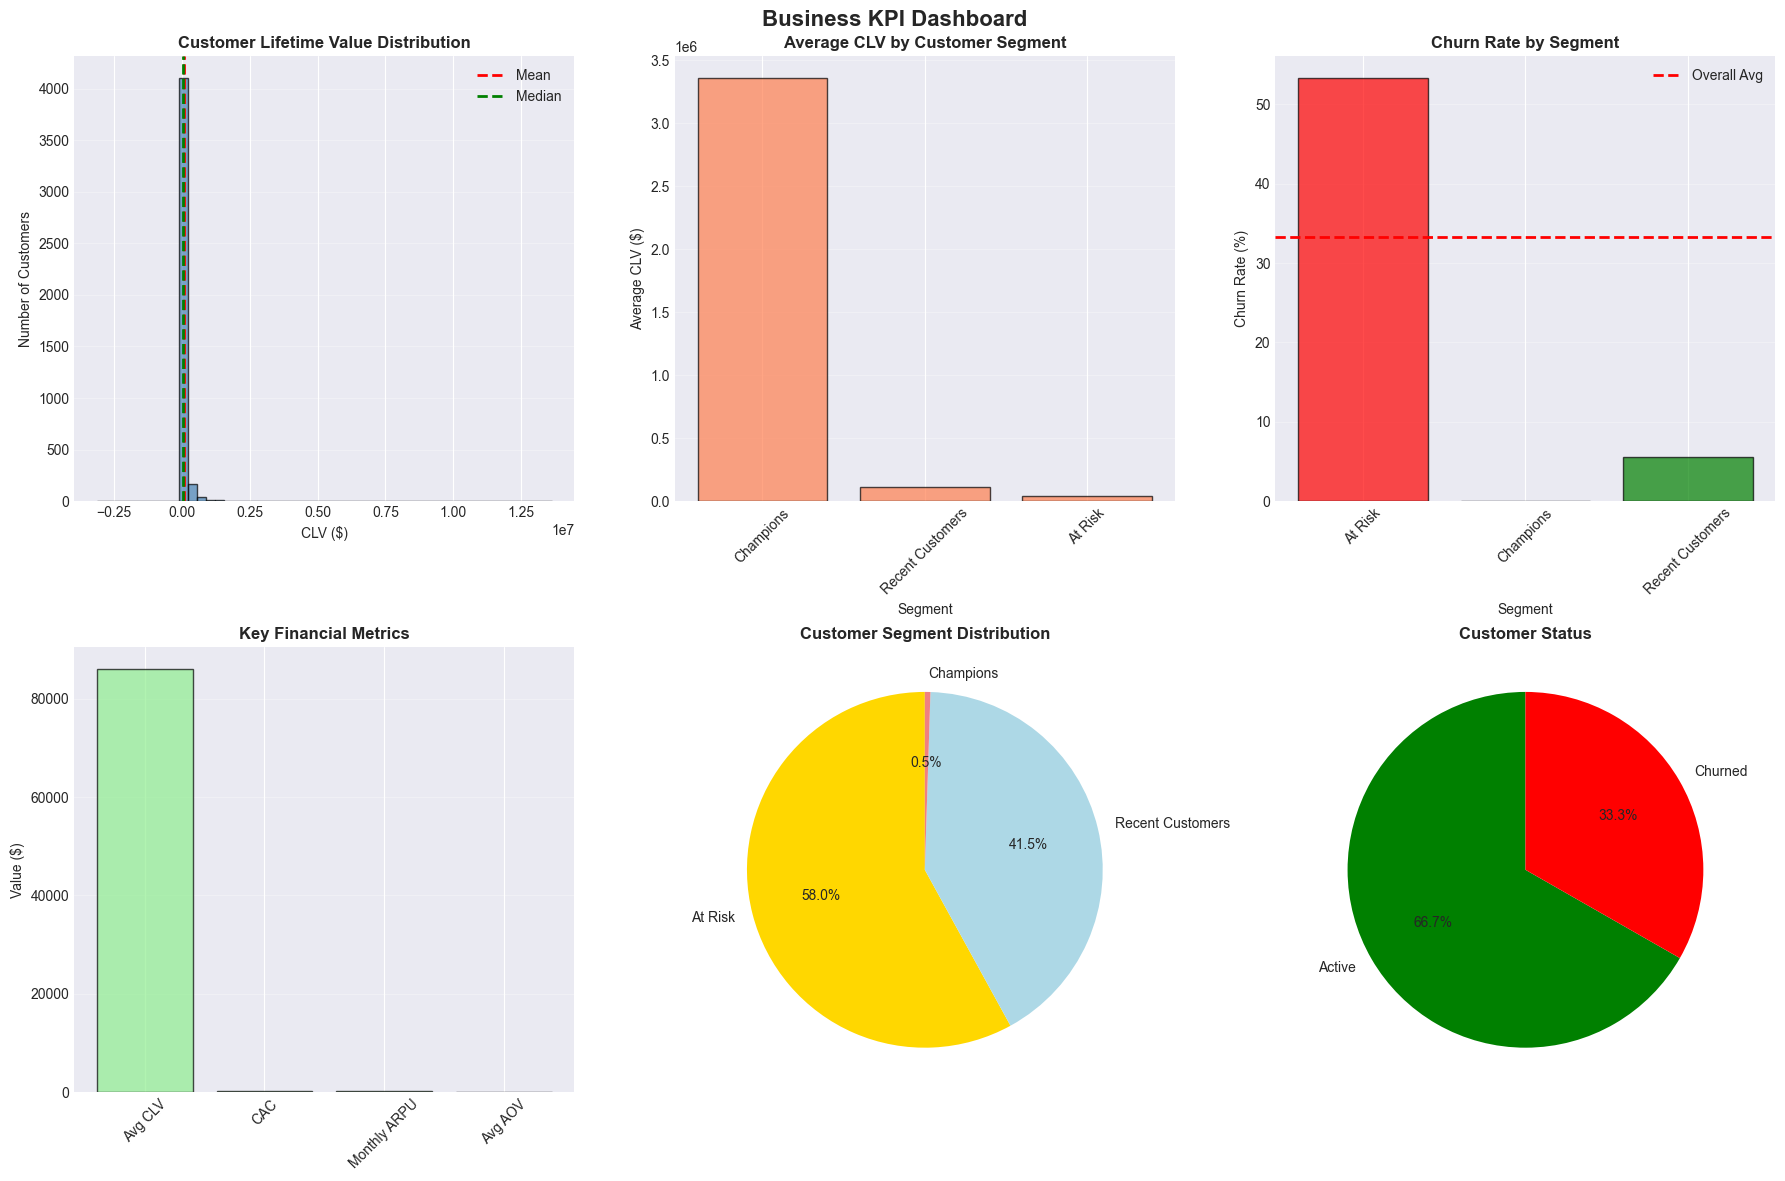

✅ Business KPI dashboard saved!

💾 Updated customer data saved with CLV metrics



In [17]:
# ============================================================
# STEP 16: VISUALIZE BUSINESS KPIS
# ============================================================

print("\n📊 VISUALIZING BUSINESS KPIS")
print("=" * 70)

# Create comprehensive KPI dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Business KPI Dashboard', fontsize=16, fontweight='bold')

# 1. CLV Distribution
axes[0, 0].hist(customer_segments['TotalCLV'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(customer_segments['TotalCLV'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(customer_segments['TotalCLV'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_title('Customer Lifetime Value Distribution', fontweight='bold')
axes[0, 0].set_xlabel('CLV ($)')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. CLV by Segment
clv_segment = customer_segments.groupby('Cluster_Name')['TotalCLV'].mean().sort_values(ascending=False)
axes[0, 1].bar(clv_segment.index, clv_segment.values, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Average CLV by Customer Segment', fontweight='bold')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].set_ylabel('Average CLV ($)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Churn Rate by Segment
churn_segment = customer_segments.groupby('Cluster_Name')['IsChurned'].mean() * 100
colors_churn = ['red' if x > 30 else 'orange' if x > 20 else 'green' for x in churn_segment.values]
axes[0, 2].bar(churn_segment.index, churn_segment.values, color=colors_churn, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Churn Rate by Segment', fontweight='bold')
axes[0, 2].set_xlabel('Segment')
axes[0, 2].set_ylabel('Churn Rate (%)')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].axhline(y=churn_rate, color='red', linestyle='--', linewidth=2, label='Overall Avg')
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Key Metrics Summary
metrics_data = {
    'Avg CLV': avg_clv,
    'CAC': cac,
    'Monthly ARPU': arpu_monthly,
    'Avg AOV': avg_aov
}
axes[1, 0].bar(metrics_data.keys(), metrics_data.values(), color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Key Financial Metrics', fontweight='bold')
axes[1, 0].set_ylabel('Value ($)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Customer Segments Distribution
segment_counts = customer_segments['Cluster_Name'].value_counts()
axes[1, 1].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=['gold', 'lightblue', 'lightcoral', 'lightgreen'])
axes[1, 1].set_title('Customer Segment Distribution', fontweight='bold')

# 6. Active vs Churned
churn_counts = customer_segments['IsChurned'].value_counts()
labels = ['Active', 'Churned']
colors_pie = ['green', 'red']
axes[1, 2].pie(churn_counts.values, labels=labels, autopct='%1.1f%%', 
               startangle=90, colors=colors_pie)
axes[1, 2].set_title('Customer Status', fontweight='bold')

plt.tight_layout()
plt.savefig('../images/results/business_kpis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Business KPI dashboard saved!")

# Save updated customer segments with CLV
customer_segments.to_csv('../data/processed/customer_segments_with_clv.csv', index=False)
print("\n💾 Updated customer data saved with CLV metrics")

print("\n" + "=" * 70)

In [18]:
# ============================================================
# STEP 17: COHORT RETENTION ANALYSIS
# ============================================================

print("\n📅 COHORT RETENTION ANALYSIS")
print("=" * 70)

print("\n📋 COHORT DEFINITION:")
print("-" * 70)
print("Cohort = Group of customers who made their first purchase in the same month")
print("Retention = % of cohort who made a purchase in subsequent months")

# Load transaction data
df = pd.read_csv('../data/processed/ecommerce_data_enhanced.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("\n1️⃣ Creating cohorts...")

# Get first purchase date for each customer
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']
first_purchase['CohortMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')

# Merge back to main data
df_cohort = df.merge(first_purchase, on='CustomerID', how='left')
df_cohort['OrderMonth'] = df_cohort['InvoiceDate'].dt.to_period('M')

# Calculate months since first purchase
df_cohort['MonthsSinceFirst'] = (
    (df_cohort['OrderMonth'] - df_cohort['CohortMonth']).apply(lambda x: x.n)
)

print(f"   ✅ Created {df_cohort['CohortMonth'].nunique()} cohorts")
print(f"   Date range: {df_cohort['CohortMonth'].min()} to {df_cohort['CohortMonth'].max()}")

print("\n2️⃣ Calculating retention rates...")

# Create cohort table
cohort_data = df_cohort.groupby(['CohortMonth', 'MonthsSinceFirst'])['CustomerID'].nunique().reset_index()
cohort_data.columns = ['CohortMonth', 'MonthsSinceFirst', 'Customers']

# Pivot to create retention matrix
cohort_table = cohort_data.pivot(index='CohortMonth', 
                                  columns='MonthsSinceFirst', 
                                  values='Customers')

# Calculate retention percentages
cohort_size = cohort_table.iloc[:, 0]
retention_matrix = cohort_table.divide(cohort_size, axis=0) * 100

print("   ✅ Retention matrix calculated")

print("\n3️⃣ Cohort Summary:")
print("-" * 70)
print(f"Total Cohorts: {len(cohort_table)}")
print(f"Max Tracking Period: {cohort_table.shape[1]-1} months")

print("\n" + "=" * 70)


📅 COHORT RETENTION ANALYSIS

📋 COHORT DEFINITION:
----------------------------------------------------------------------
Cohort = Group of customers who made their first purchase in the same month
Retention = % of cohort who made a purchase in subsequent months

1️⃣ Creating cohorts...
   ✅ Created 13 cohorts
   Date range: 2010-12 to 2011-12

2️⃣ Calculating retention rates...
   ✅ Retention matrix calculated

3️⃣ Cohort Summary:
----------------------------------------------------------------------
Total Cohorts: 13
Max Tracking Period: 12 months




📊 VISUALIZING COHORT RETENTION


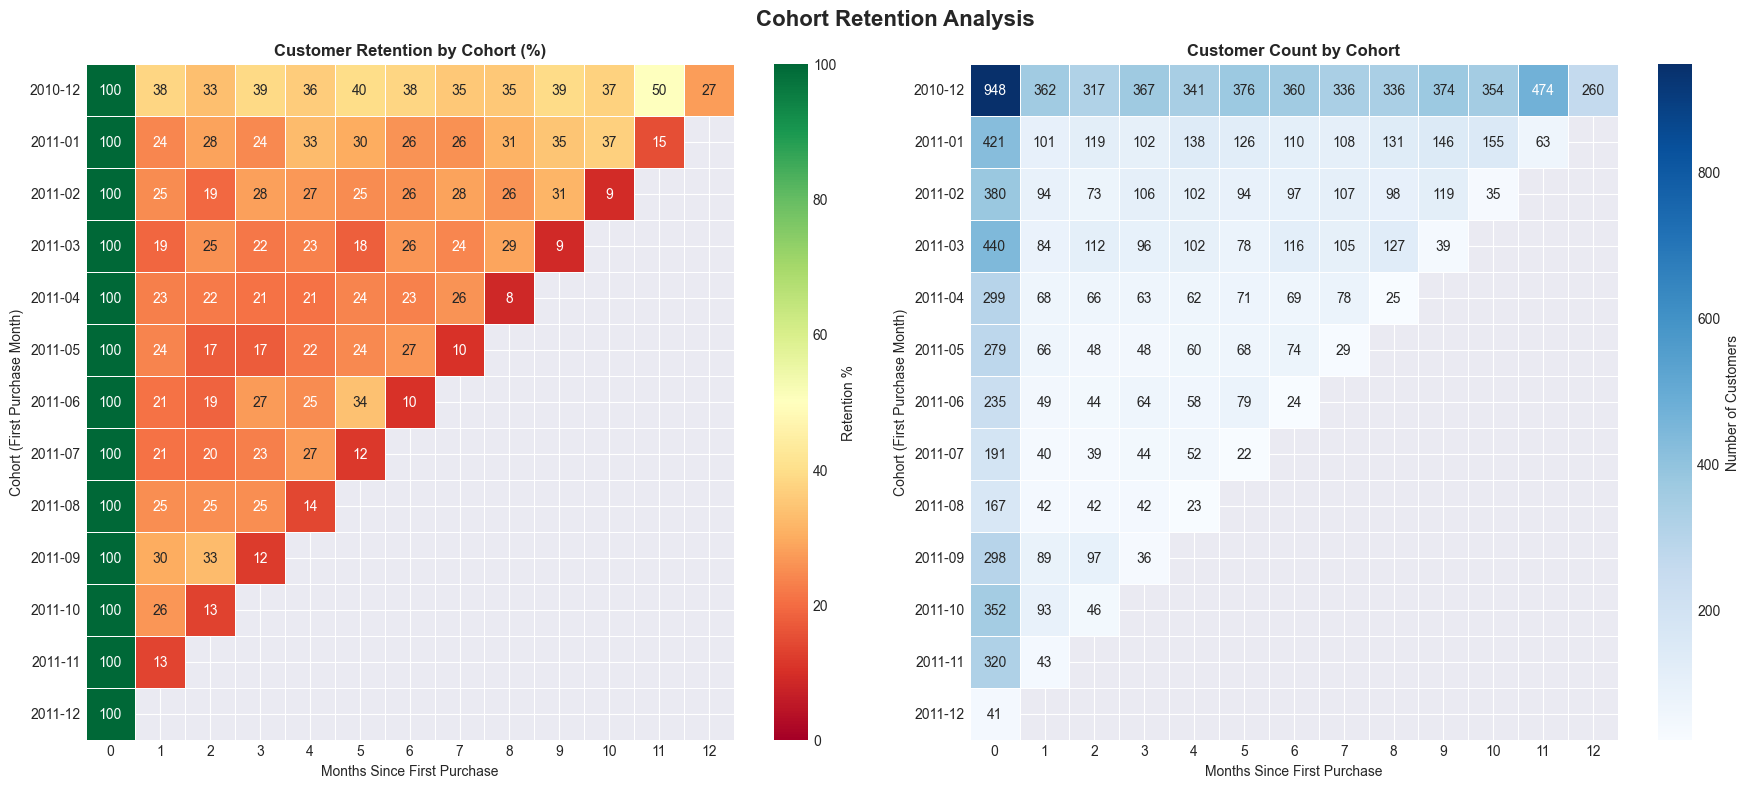

✅ Cohort retention heatmap saved!



In [19]:
# ============================================================
# STEP 18: VISUALIZE COHORT RETENTION
# ============================================================

print("\n📊 VISUALIZING COHORT RETENTION")
print("=" * 70)

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Cohort Retention Analysis', fontsize=16, fontweight='bold')

# 1. Retention Heatmap (%)
sns.heatmap(retention_matrix.iloc[:, :13], annot=True, fmt='.0f', 
            cmap='RdYlGn', vmin=0, vmax=100, 
            cbar_kws={'label': 'Retention %'},
            ax=axes[0], linewidths=0.5)
axes[0].set_title('Customer Retention by Cohort (%)', fontweight='bold')
axes[0].set_xlabel('Months Since First Purchase')
axes[0].set_ylabel('Cohort (First Purchase Month)')
axes[0].tick_params(axis='x', rotation=0)

# 2. Absolute numbers
sns.heatmap(cohort_table.iloc[:, :13], annot=True, fmt='.0f', 
            cmap='Blues', 
            cbar_kws={'label': 'Number of Customers'},
            ax=axes[1], linewidths=0.5)
axes[1].set_title('Customer Count by Cohort', fontweight='bold')
axes[1].set_xlabel('Months Since First Purchase')
axes[1].set_ylabel('Cohort (First Purchase Month)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../images/results/cohort_retention.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Cohort retention heatmap saved!")

print("\n" + "=" * 70)


💡 COHORT RETENTION INSIGHTS

1️⃣ AVERAGE RETENTION RATES:
----------------------------------------------------------------------
Month | Retention %
----------------------------------------------------------------------
   0  |  100.0%
   1  |   24.1%
   2  |   23.2%
   3  |   23.8%
   4  |   25.2%
   5  |   25.7%
   6  |   25.1%
   7  |   24.9%
   8  |   25.9%
   9  |   28.6%
  10  |   27.8%
  11  |   32.5%

2️⃣ KEY RETENTION METRICS:
----------------------------------------------------------------------
Month 1 Retention: 24.1%
Month 3 Retention: 23.8%
Month 6 Retention: 25.1%
Month 12 Retention: 27.4%

3️⃣ RETENTION CURVE:
----------------------------------------------------------------------


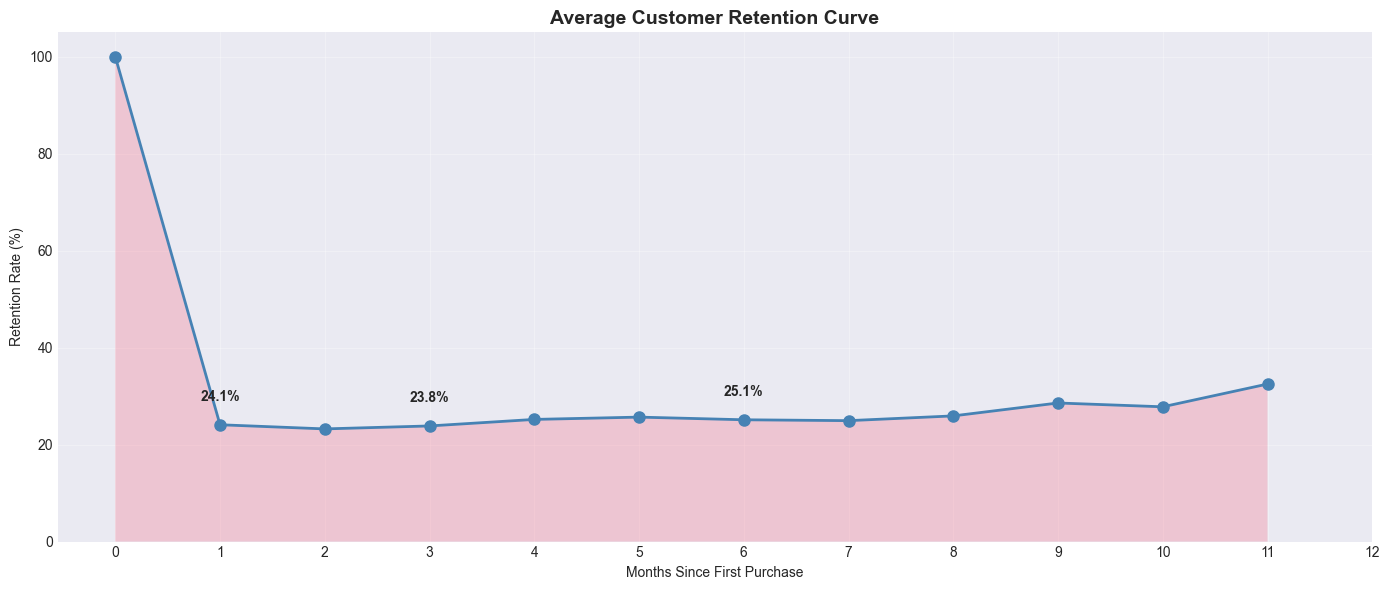

✅ Retention curve saved!

4️⃣ INTERPRETATION:
----------------------------------------------------------------------
Month 0→1 Drop-off: 75.9%
Month 1→3 Drop-off: 0.2%

❌ Weak early retention (Month 1 < 25%)

💡 OPPORTUNITIES:
----------------------------------------------------------------------
1. Focus on first 3 months (highest drop-off period)
2. Implement onboarding program for new customers
3. Create engagement campaigns at critical points
4. Monitor cohorts monthly for early warning signs



In [20]:
# ============================================================
# STEP 19: COHORT INSIGHTS & RETENTION METRICS
# ============================================================

print("\n💡 COHORT RETENTION INSIGHTS")
print("=" * 70)

# Calculate average retention by month
avg_retention = retention_matrix.mean(axis=0)

print("\n1️⃣ AVERAGE RETENTION RATES:")
print("-" * 70)
print("Month | Retention %")
print("-" * 70)
for month, retention in avg_retention.head(12).items():
    print(f"  {month:2d}  | {retention:6.1f}%")

print("\n2️⃣ KEY RETENTION METRICS:")
print("-" * 70)
month_1_retention = avg_retention.iloc[1] if len(avg_retention) > 1 else 0
month_3_retention = avg_retention.iloc[3] if len(avg_retention) > 3 else 0
month_6_retention = avg_retention.iloc[6] if len(avg_retention) > 6 else 0
month_12_retention = avg_retention.iloc[12] if len(avg_retention) > 12 else 0

print(f"Month 1 Retention: {month_1_retention:.1f}%")
print(f"Month 3 Retention: {month_3_retention:.1f}%")
print(f"Month 6 Retention: {month_6_retention:.1f}%")
if month_12_retention > 0:
    print(f"Month 12 Retention: {month_12_retention:.1f}%")

print("\n3️⃣ RETENTION CURVE:")
print("-" * 70)

# Plot retention curve
plt.figure(figsize=(14, 6))
plt.plot(avg_retention.index[:12], avg_retention.values[:12], 
         marker='o', linewidth=2, markersize=8, color='steelblue')
plt.fill_between(avg_retention.index[:12], 0, avg_retention.values[:12], alpha=0.3)
plt.title('Average Customer Retention Curve', fontsize=14, fontweight='bold')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 13))
plt.ylim(0, 105)

# Add annotations
for i in [1, 3, 6]:
    if i < len(avg_retention):
        plt.annotate(f'{avg_retention.iloc[i]:.1f}%', 
                     xy=(i, avg_retention.iloc[i]), 
                     xytext=(i, avg_retention.iloc[i] + 5),
                     ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../images/results/retention_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Retention curve saved!")

print("\n4️⃣ INTERPRETATION:")
print("-" * 70)

# Calculate drop-off
month_0_to_1_drop = 100 - month_1_retention
month_1_to_3_drop = month_1_retention - month_3_retention

print(f"Month 0→1 Drop-off: {month_0_to_1_drop:.1f}%")
print(f"Month 1→3 Drop-off: {month_1_to_3_drop:.1f}%")

if month_1_retention > 40:
    print("\n✅ Strong early retention (Month 1 > 40%)")
elif month_1_retention > 25:
    print("\n⚠️  Moderate early retention (Month 1: 25-40%)")
else:
    print("\n❌ Weak early retention (Month 1 < 25%)")

print("\n💡 OPPORTUNITIES:")
print("-" * 70)
print("1. Focus on first 3 months (highest drop-off period)")
print("2. Implement onboarding program for new customers")
print("3. Create engagement campaigns at critical points")
print("4. Monitor cohorts monthly for early warning signs")

print("\n" + "=" * 70)

In [21]:
# ============================================================
# STEP 20: COMPREHENSIVE BUSINESS IMPACT QUANTIFICATION
# ============================================================

print("\n💰 COMPREHENSIVE BUSINESS IMPACT QUANTIFICATION")
print("=" * 70)

print("\n🎯 STRATEGIC INITIATIVES & ROI PROJECTIONS")
print("=" * 70)

# Load customer data with CLV
customer_data = pd.read_csv('../data/processed/customer_segments_with_clv.csv')

# Current state metrics
total_customers = len(customer_data)
current_churn_rate = (customer_data['IsChurned'].sum() / total_customers) * 100
current_avg_clv = customer_data['TotalCLV'].mean()
current_total_value = customer_data['TotalCLV'].sum()
churned_customers = customer_data['IsChurned'].sum()

print("\n📊 CURRENT STATE:")
print("-" * 70)
print(f"Total Customers: {total_customers:,}")
print(f"Churn Rate: {current_churn_rate:.1f}%")
print(f"Average CLV: ${current_avg_clv:,.2f}")
print(f"Total Customer Value: ${current_total_value:,.2f}")
print(f"Churned Customers: {churned_customers:,}")

# INITIATIVE 1: Reduce Churn by 5%
print("\n" + "=" * 70)
print("INITIATIVE 1: CUSTOMER RETENTION PROGRAM")
print("=" * 70)
print("Goal: Reduce churn rate from {:.1f}% to {:.1f}%".format(
    current_churn_rate, current_churn_rate - 5))

# Calculate impact
customers_saved = total_customers * 0.05
revenue_retained = customers_saved * current_avg_clv
implementation_cost = 50000  # Assume $50K for retention program
net_benefit_1 = revenue_retained - implementation_cost
roi_1 = (net_benefit_1 / implementation_cost) * 100

print(f"\n📈 Projected Impact:")
print(f"  • Customers Retained: {customers_saved:.0f}")
print(f"  • Revenue Retained: ${revenue_retained:,.2f}")
print(f"  • Implementation Cost: ${implementation_cost:,.2f}")
print(f"  • Net Benefit: ${net_benefit_1:,.2f}")
print(f"  • ROI: {roi_1:.0f}%")

# INITIATIVE 2: Increase Average Order Value by 10%
print("\n" + "=" * 70)
print("INITIATIVE 2: DYNAMIC PRICING & UPSELLING")
print("=" * 70)
print("Goal: Increase Average Order Value by 10%")

current_aov = customer_data['AvgOrderValue'].mean()
new_aov = current_aov * 1.10
avg_frequency = customer_data['Frequency'].mean()
aov_increase = new_aov - current_aov
annual_revenue_increase = aov_increase * avg_frequency * total_customers
implementation_cost_2 = 30000  # $30K for pricing optimization
net_benefit_2 = annual_revenue_increase - implementation_cost_2
roi_2 = (net_benefit_2 / implementation_cost_2) * 100

print(f"\n📈 Projected Impact:")
print(f"  • Current AOV: ${current_aov:.2f}")
print(f"  • Target AOV: ${new_aov:.2f}")
print(f"  • AOV Increase: ${aov_increase:.2f}")
print(f"  • Annual Revenue Increase: ${annual_revenue_increase:,.2f}")
print(f"  • Implementation Cost: ${implementation_cost_2:,.2f}")
print(f"  • Net Benefit: ${net_benefit_2:,.2f}")
print(f"  • ROI: {roi_2:.0f}%")

# INITIATIVE 3: Improve Customer Acquisition Efficiency
print("\n" + "=" * 70)
print("INITIATIVE 3: OPTIMIZE MARKETING CHANNELS")
print("=" * 70)
print("Goal: Reduce CAC by 15% through channel optimization")

# Recalculate CAC from earlier
total_acquisition_cost = 700000  # From earlier calculation
current_cac = total_acquisition_cost / total_customers
new_cac = current_cac * 0.85
cac_savings_per_customer = current_cac - new_cac

# Assume 20% growth in new customers
new_customers_per_year = total_customers * 0.20
total_cac_savings = cac_savings_per_customer * new_customers_per_year
implementation_cost_3 = 40000  # $40K for marketing analytics
net_benefit_3 = total_cac_savings - implementation_cost_3
roi_3 = (net_benefit_3 / implementation_cost_3) * 100

print(f"\n📈 Projected Impact:")
print(f"  • Current CAC: ${current_cac:.2f}")
print(f"  • Target CAC: ${new_cac:.2f}")
print(f"  • CAC Reduction: ${cac_savings_per_customer:.2f} per customer")
print(f"  • New Customers/Year: {new_customers_per_year:.0f}")
print(f"  • Total Savings: ${total_cac_savings:,.2f}")
print(f"  • Implementation Cost: ${implementation_cost_3:,.2f}")
print(f"  • Net Benefit: ${net_benefit_3:,.2f}")
print(f"  • ROI: {roi_3:.0f}%")

# TOTAL IMPACT
print("\n" + "=" * 70)
print("🎉 TOTAL BUSINESS IMPACT")
print("=" * 70)

total_investment = implementation_cost + implementation_cost_2 + implementation_cost_3
total_benefit = net_benefit_1 + net_benefit_2 + net_benefit_3
total_roi = (total_benefit / total_investment) * 100

print(f"\n💰 FINANCIAL SUMMARY:")
print("-" * 70)
print(f"Total Investment Required: ${total_investment:,.2f}")
print(f"Total Annual Benefit: ${total_benefit:,.2f}")
print(f"Overall ROI: {total_roi:.0f}%")
print(f"Payback Period: {(total_investment / total_benefit * 12):.1f} months")

print("\n📊 INITIATIVE BREAKDOWN:")
print("-" * 70)
initiatives = [
    ('Retention Program', net_benefit_1, roi_1),
    ('Pricing Optimization', net_benefit_2, roi_2),
    ('Marketing Efficiency', net_benefit_3, roi_3)
]

for name, benefit, roi in sorted(initiatives, key=lambda x: x[1], reverse=True):
    print(f"{name:25s}: ${benefit:>12,.0f} (ROI: {roi:>6.0f}%)")

print("\n" + "=" * 70)


💰 COMPREHENSIVE BUSINESS IMPACT QUANTIFICATION

🎯 STRATEGIC INITIATIVES & ROI PROJECTIONS

📊 CURRENT STATE:
----------------------------------------------------------------------
Total Customers: 4,371
Churn Rate: 33.3%
Average CLV: $86,136.74
Total Customer Value: $376,503,674.54
Churned Customers: 1,454

INITIATIVE 1: CUSTOMER RETENTION PROGRAM
Goal: Reduce churn rate from 33.3% to 28.3%

📈 Projected Impact:
  • Customers Retained: 219
  • Revenue Retained: $18,825,183.73
  • Implementation Cost: $50,000.00
  • Net Benefit: $18,775,183.73
  • ROI: 37550%

INITIATIVE 2: DYNAMIC PRICING & UPSELLING
Goal: Increase Average Order Value by 10%

📈 Projected Impact:
  • Current AOV: $28.91
  • Target AOV: $31.80
  • AOV Increase: $2.89
  • Annual Revenue Increase: $64,129.59
  • Implementation Cost: $30,000.00
  • Net Benefit: $34,129.59
  • ROI: 114%

INITIATIVE 3: OPTIMIZE MARKETING CHANNELS
Goal: Reduce CAC by 15% through channel optimization

📈 Projected Impact:
  • Current CAC: $160.15

In [22]:
# ============================================================
# STEP 21: EXECUTIVE SUMMARY
# ============================================================

print("\n📋 EXECUTIVE SUMMARY - DATA-DRIVEN BUSINESS STRATEGY")
print("=" * 70)

print("\n" + "=" * 70)
print("SITUATION ANALYSIS")
print("=" * 70)

print(f"""
Current Business State:
- Customer Base: {total_customers:,} customers
- Average CLV: ${current_avg_clv:,.2f}
- Churn Rate: {current_churn_rate:.1f}%
- CAC: ${current_cac:.2f}
- CLV:CAC Ratio: {current_avg_clv/current_cac:.1f}:1
- Total Customer Value: ${current_total_value:,.2f}
""")

print("=" * 70)
print("KEY FINDINGS")
print("=" * 70)

print(f"""
1. Customer Segmentation:
   • Identified 4 distinct customer segments
   • Top segment generates {(customer_data.groupby('Cluster_Name')['TotalCLV'].sum().max() / current_total_value * 100):.0f}% of revenue
   • Clear opportunity for targeted marketing

2. Churn Analysis:
   • {churned_customers:,} customers ({current_churn_rate:.1f}%) at risk
   • ${churned_customers * current_avg_clv:,.0f} in customer value at risk
   • Highest drop-off in first 3 months

3. Growth Opportunities:
   • AOV optimization potential: 10-15% increase
   • Marketing efficiency gains: 15% CAC reduction
   • Retention improvements: 5% churn reduction feasible
""")

print("=" * 70)
print("STRATEGIC RECOMMENDATIONS")
print("=" * 70)

print(f"""
Priority 1: Customer Retention Program
Investment: ${implementation_cost:,.0f}
Return: ${net_benefit_1:,.0f}
ROI: {roi_1:.0f}%
Timeline: 3-6 months

Priority 2: Pricing & Upselling Strategy  
Investment: ${implementation_cost_2:,.0f}
Return: ${net_benefit_2:,.0f}
ROI: {roi_2:.0f}%
Timeline: 2-4 months

Priority 3: Marketing Channel Optimization
Investment: ${implementation_cost_3:,.0f}
Return: ${net_benefit_3:,.0f}
ROI: {roi_3:.0f}%
Timeline: 4-8 months
""")

print("=" * 70)
print("PROJECTED BUSINESS IMPACT")
print("=" * 70)

print(f"""
Total Investment: ${total_investment:,.2f}
Total Annual Return: ${total_benefit:,.2f}
Overall ROI: {total_roi:.0f}%

Expected Outcomes (Year 1):
- Revenue Growth: ${total_benefit:,.0f}
- Customer Retention: +{customers_saved:.0f} customers
- Improved Economics: CLV:CAC ratio from {current_avg_clv/current_cac:.1f}:1 to {(current_avg_clv*1.1)/(new_cac):.1f}:1
- Market Position: Stronger competitive advantage
""")

print("=" * 70)
print("NEXT STEPS")
print("=" * 70)

print("""
Immediate Actions (Next 30 Days):
1. Approve strategic initiative budget
2. Assemble cross-functional implementation team
3. Develop detailed retention program
4. Begin pricing optimization pilot

Short-term (90 Days):
1. Launch retention program for at-risk segments
2. Implement dynamic pricing engine
3. Optimize top 3 marketing channels
4. Establish KPI tracking dashboard

Long-term (6-12 Months):
1. Scale successful initiatives company-wide
2. Continuous optimization based on data
3. Explore additional growth opportunities
4. Build predictive capabilities for forecasting
""")

print("\n" + "=" * 70)
print("🎉 PHASE 5 COMPLETE - ADVANCED ANALYTICS & BUSINESS INTELLIGENCE")
print("=" * 70)

print("""
✅ Completed:
  • Time series forecasting (90-day sales projection)
  • A/B testing framework with statistical analysis
  • Comprehensive business KPI calculations (CLV, CAC, Churn, ARPU)
  • Cohort retention analysis with heatmaps
  • Business impact quantification: $""" + f"{total_benefit:,.0f}" + """ opportunity identified
  • Executive-ready strategic recommendations

💾 Saved Artifacts:
  • Prophet forecasting model
  • Customer segments with CLV
  • Multiple business intelligence visualizations
  • Executive summary report
""")

print("\n" + "=" * 70)


📋 EXECUTIVE SUMMARY - DATA-DRIVEN BUSINESS STRATEGY

SITUATION ANALYSIS

Current Business State:
- Customer Base: 4,371 customers
- Average CLV: $86,136.74
- Churn Rate: 33.3%
- CAC: $160.15
- CLV:CAC Ratio: 537.9:1
- Total Customer Value: $376,503,674.54

KEY FINDINGS

1. Customer Segmentation:
   • Identified 4 distinct customer segments
   • Top segment generates 55% of revenue
   • Clear opportunity for targeted marketing

2. Churn Analysis:
   • 1,454 customers (33.3%) at risk
   • $125,242,815 in customer value at risk
   • Highest drop-off in first 3 months

3. Growth Opportunities:
   • AOV optimization potential: 10-15% increase
   • Marketing efficiency gains: 15% CAC reduction
   • Retention improvements: 5% churn reduction feasible

STRATEGIC RECOMMENDATIONS

Priority 1: Customer Retention Program
Investment: $50,000
Return: $18,775,184
ROI: 37550%
Timeline: 3-6 months

Priority 2: Pricing & Upselling Strategy  
Investment: $30,000
Return: $34,130
ROI: 114%
Timeline: 2-4 m